In [1]:
import pandas as pd
from datetime import datetime

In [2]:
# loading data
import os

pwd = os.getcwd()

dataset = pd.read_csv(pwd + '/merged_data.csv', index_col=0)
dataset.head()

,Open,Close,Change,sentiment,sentiment_score
Date,,,,,
2025-01-10,3761.549,3736.886,-0.66,0,0.700804
2024-12-19,3780.106,3708.531,-1.93,0,0.950467
2024-12-18,3774.744,3781.551,0.18,1,0.460880
2024-12-16,3748.220,3765.163,0.45,1,0.771217
2024-12-12,3744.519,3748.267,0.10,1,0.927686


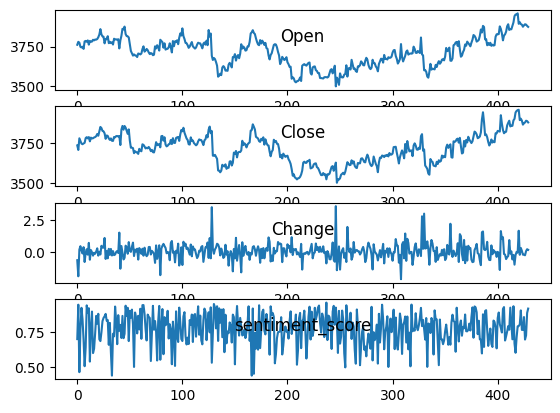

In [3]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 4]
i = 1

# plot each column
pyplot.figure()

for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='center')
    i += 1
pyplot.show()

# LSTM Prep and Implementation

The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

In [4]:
# prepare data for lstm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# load dataset
dataset = pd.read_csv(pwd + '/merged_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'],
      dtype='object')


In [ ]:
reframed.drop(reframed.columns[[5,7,8,9]], axis=1, inplace=True)  # drop all except var2(t) (Close price)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var2(t)
1   0.569602   0.511649   0.259965        0.5   0.500127  0.449717
2   0.609718   0.449717   0.039861        0.5   0.971249  0.609205
3   0.598126   0.609205   0.405546        1.0   0.047382  0.573411
4   0.540788   0.573411   0.452340        1.0   0.633000  0.536507
5   0.532787   0.536507   0.391681        1.0   0.928260  0.528172


In [ ]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(343, 1, 5) (343,) (86, 1, 5) (86,)


In [8]:
n_samples = train_X.shape[0]
n_features = train_X.shape[2]

print(n_samples)
print(n_features)

343
5


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler

model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))

model.add(MaxPooling1D(pool_size=1))

# LSTM Layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(train_X, train_y, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

# Predictions
yhat = model.predict(test_X)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 1, 50)             23000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 43635 (170.45 KB)
Trainable params: 43635 (170.45 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

3/3 [==============================] - 0s 3ms/step - loss: 0.0028
Test Loss: 0.0027609667740762234
Mean Absolute Error: 0.031072668731212616
R-squared Score: 0.9099305272102356


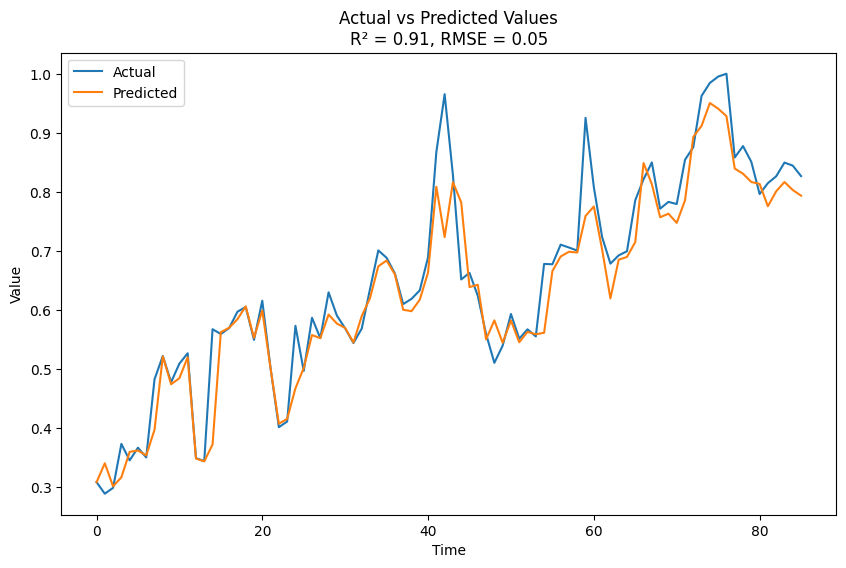

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, yhat)
mse = mean_squared_error(test_y, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, yhat)
loss = model.evaluate(test_X, test_y)

print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(yhat, label='Predicted')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_X and train_y are already defined
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []

for train_index, test_index in tscv.split(train_X):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

print(f'Mean MAE: {np.mean(mae_scores)}')
print(f'Standard Deviation of MAE: {np.std(mae_scores)}')

In [ ]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.show()

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler

# Ensure train_X has enough timesteps for Conv1D
timesteps = 1  # Set to at least 3 to match kernel_size
features = train_X.shape[1] * train_X.shape[2] // timesteps

# Reshape input for CNN-LSTM
train_X = train_X.reshape((n_samples, 1, n_features))
test_X = test_X.reshape((n_samples, 1, n_features))

# Define CNN-LSTM model
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, features)))

# MaxPooling Layer
model.add(MaxPooling1D(pool_size=1))

# LSTM Layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

# Fully Connected Dense Layer
model.add(Dense(1))

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Model Summary
model.summary()

# Train the CNN-LSTM Model
history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

# Predictions
yhat = model.predict(test_X)
